In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib
import os

2024-06-21 18:47:40.386738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 18:47:40.386831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 18:47:40.502969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_size = 256
batch_size = 32
channels = 3
epochs = 30

In [3]:
dir=os.listdir('/kaggle/input/plant-village/PlantVillage')
for i in dir:
    print(i)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
dataset_dir,
batch_size=batch_size,
image_size=(image_size, image_size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [7]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [10]:
for image_batch, labels_batch in dataset.take(2):
    print(image_batch.shape)
    print(labels_batch.numpy())
    
#với mỗi lần run output đc shuffle
#0 tương ứng với early_blight
#1 tương ứng với late_blight
#2 tương ứng với healthy

(32, 256, 256, 3)
[1 1 1 1 1 1 0 0 1 0 0 0 2 0 0 0 0 0 0 1 1 0 1 1 0 2 0 0 1 1 0 0]
(32, 256, 256, 3)
[0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 2 1 0 0 1 0 0 1]


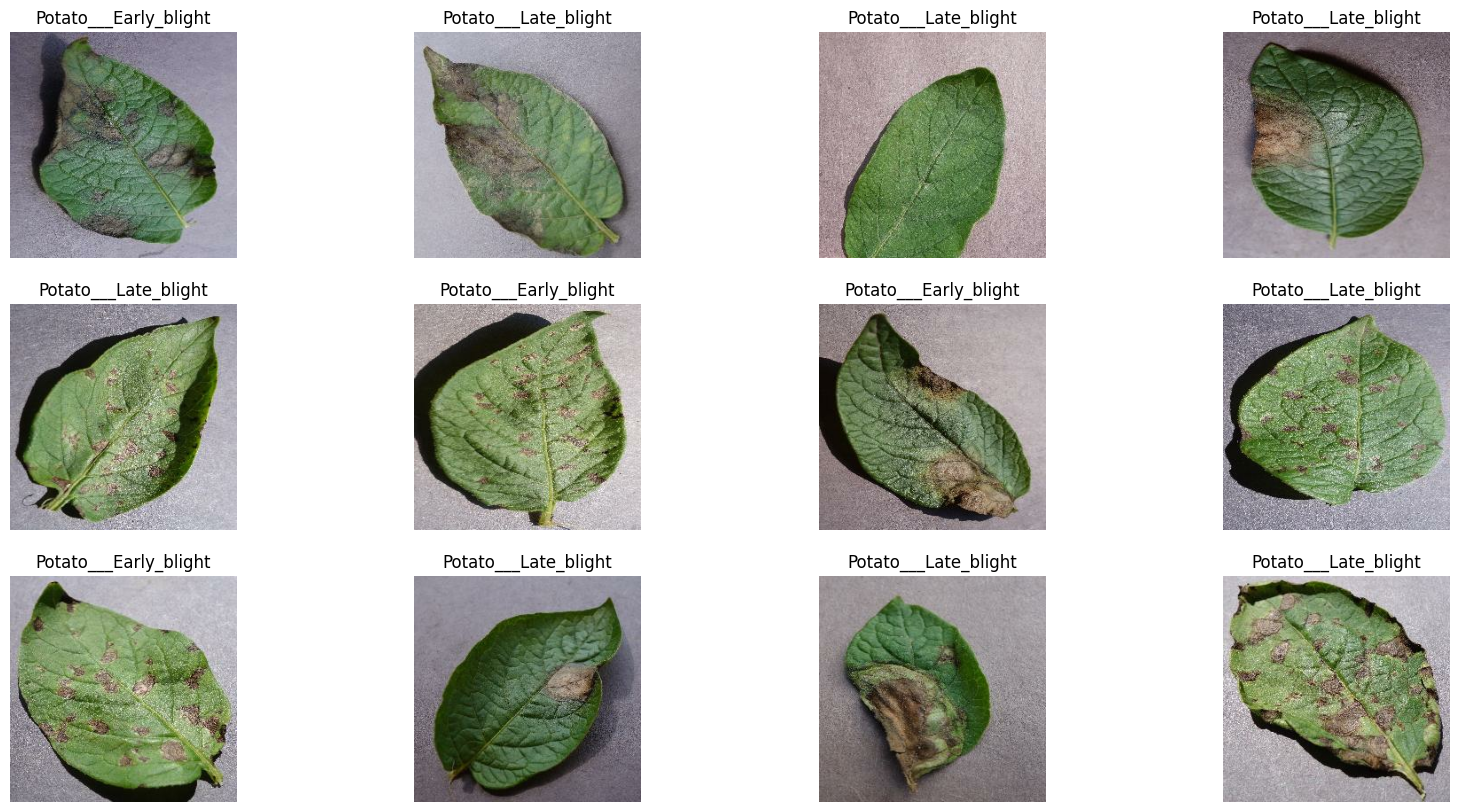

In [11]:
plt.figure(figsize=(20, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size, image_size),
  layers.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2),
#     layers.RandomTranslation(0.2, 0.2),
    # Add more data augmentation layers as needed
])

In [20]:
# #Checking what is the expected dimension order for channel
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# chanDim = -1
# if K.image_data_format() == "channels_first":
#     input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
#     batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
#     chanDim = 1

In [21]:
input_shape = (image_size, image_size, channels)
batch_input_shape = (batch_size, image_size, image_size, channels)
n_classes = 3

In [22]:
model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.4679 - loss: 0.9318 - val_accuracy: 0.5885 - val_loss: 0.8905
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7102 - loss: 0.6610 - val_accuracy: 0.7708 - val_loss: 0.5085
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7954 - loss: 0.4529 - val_accuracy: 0.8698 - val_loss: 0.3428
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8852 - loss: 0.2929 - val_accuracy: 0.8802 - val_loss: 0.2483
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9008 - loss: 0.2495 - val_accuracy: 0.8594 - val_loss: 0.3945
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8995 - loss: 0.2363 - val_accuracy: 0.9375 - val_loss: 0.1392
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9333 - loss: 0.1622 - val_accuracy: 0.8698 - val_loss: 0.2913
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9153 - loss: 0.2007 - val_accuracy: 0.9167 - 

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9807 - loss: 0.0571
Test Accuracy: 97.66%


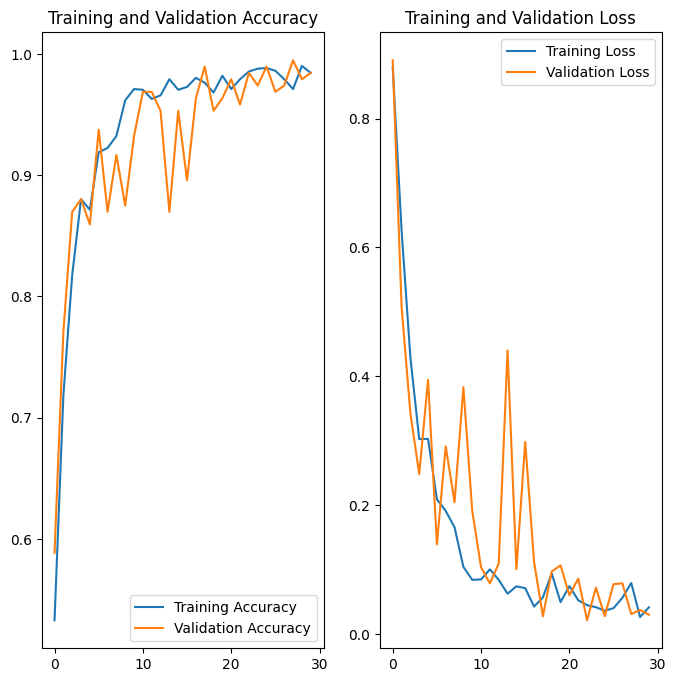

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


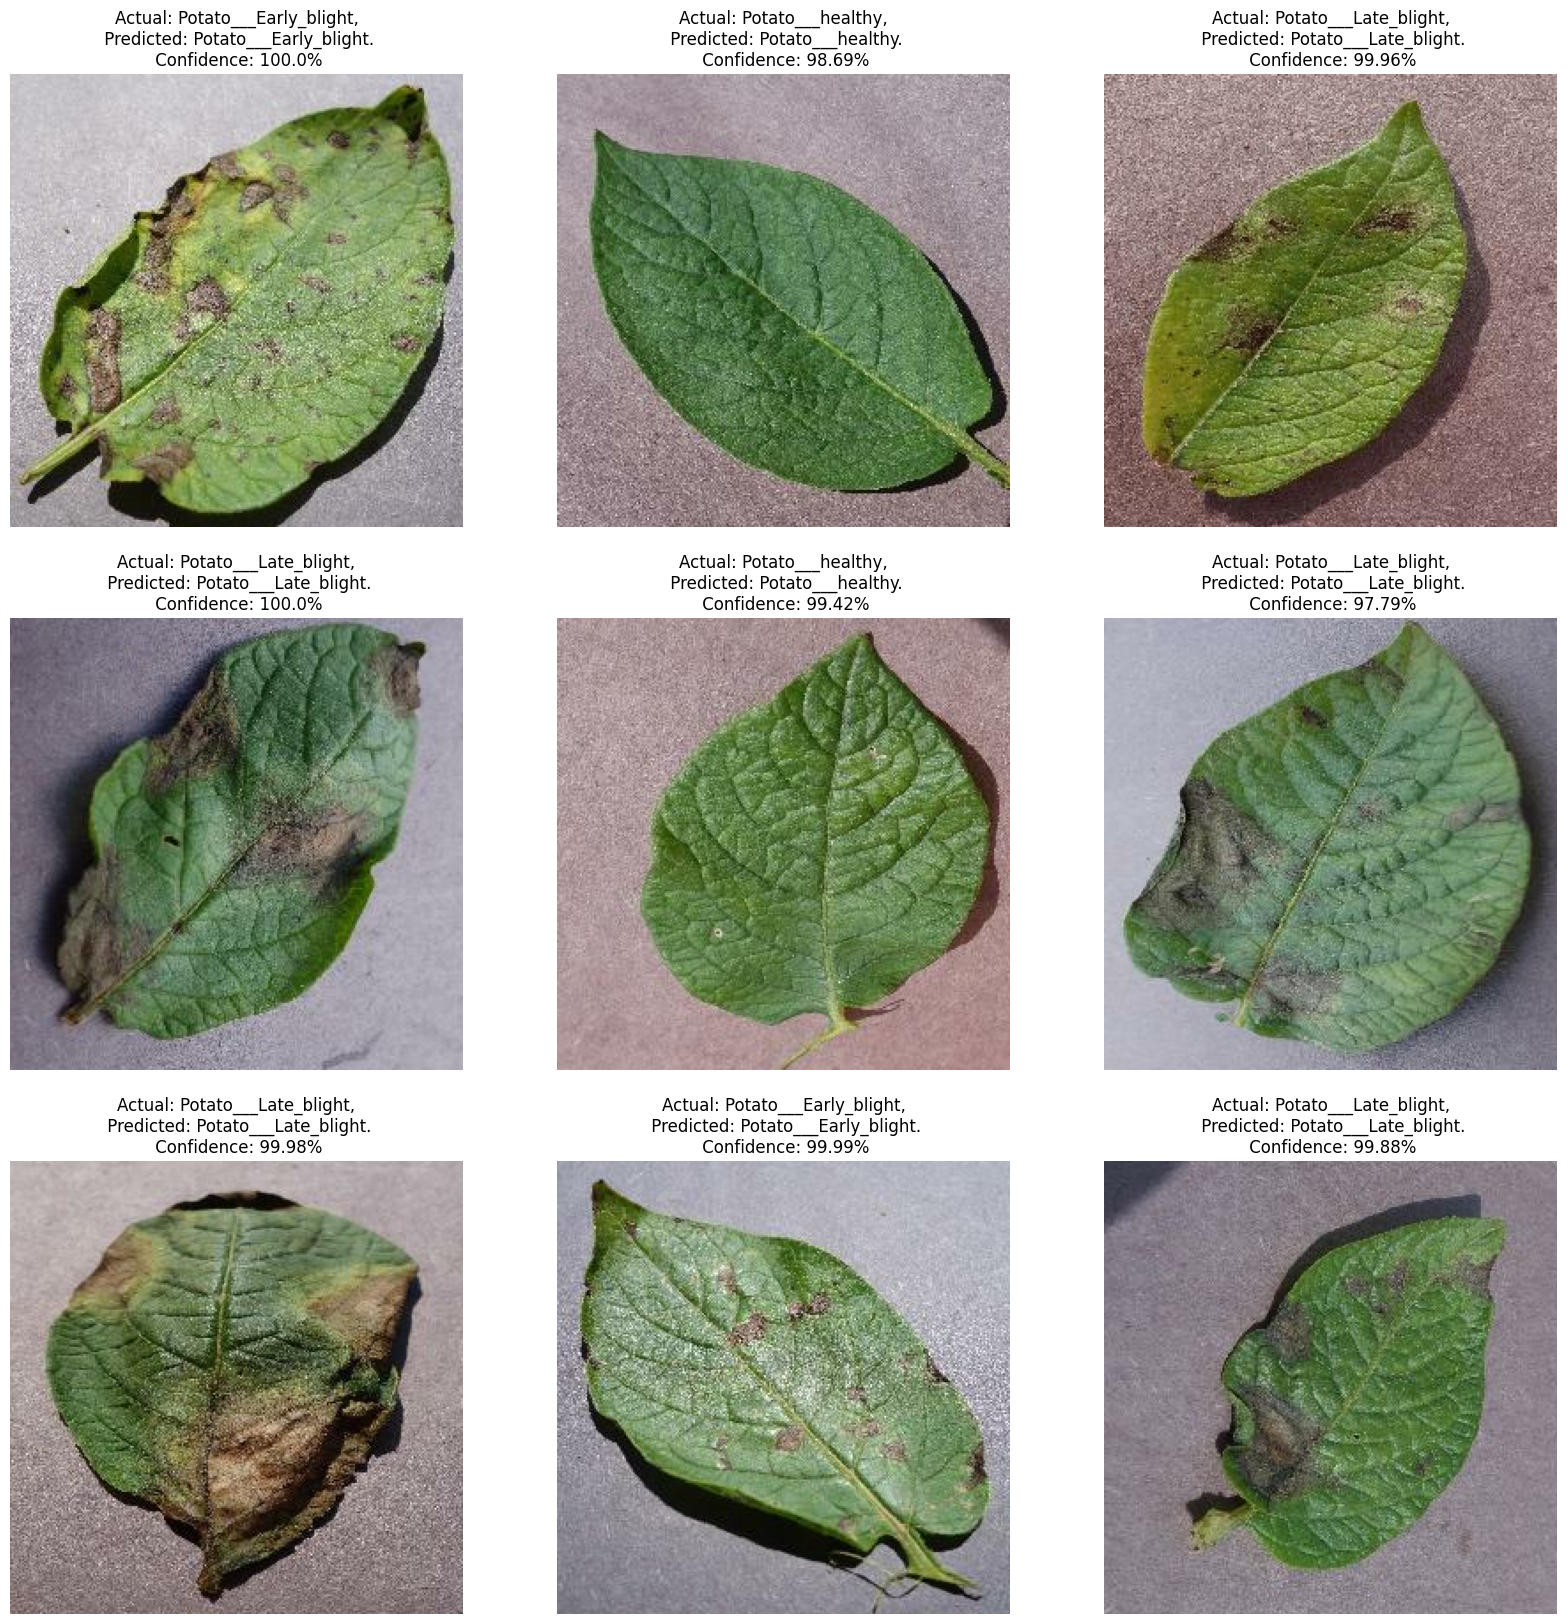

In [29]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [30]:
model_version = 1
model.save(f'/kaggle/working/Model_v{model}.keras')

In [31]:
# Ít hơn 2 layer
model1 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model1.build(input_shape=batch_input_shape)


In [32]:
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history1 = model1.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5551 - loss: 0.8885 - val_accuracy: 0.8542 - val_loss: 0.4599
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8602 - loss: 0.3948 - val_accuracy: 0.8802 - val_loss: 0.2979
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8606 - loss: 0.3201 - val_accuracy: 0.9167 - val_loss: 0.2284
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9205 - loss: 0.2090 - val_accuracy: 0.9115 - val_loss: 0.2323
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9089 - loss: 0.2466 - val_accuracy: 0.8646 - val_loss: 0.3082
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9034 - loss: 0.2385 - val_accuracy: 0.8906 - val_loss: 0.2142
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9247 - loss: 0.1883 - val_accuracy: 0.9427 - val_loss: 0.1548
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9432 - loss: 0.1539 - val_accuracy: 0.9531 - v

In [35]:
print("[INFO] Calculating model accuracy")
scores1 = model1.evaluate(test_ds)
print(f"Test Accuracy: {round(scores1[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9435 - loss: 0.1481
Test Accuracy: 93.75%


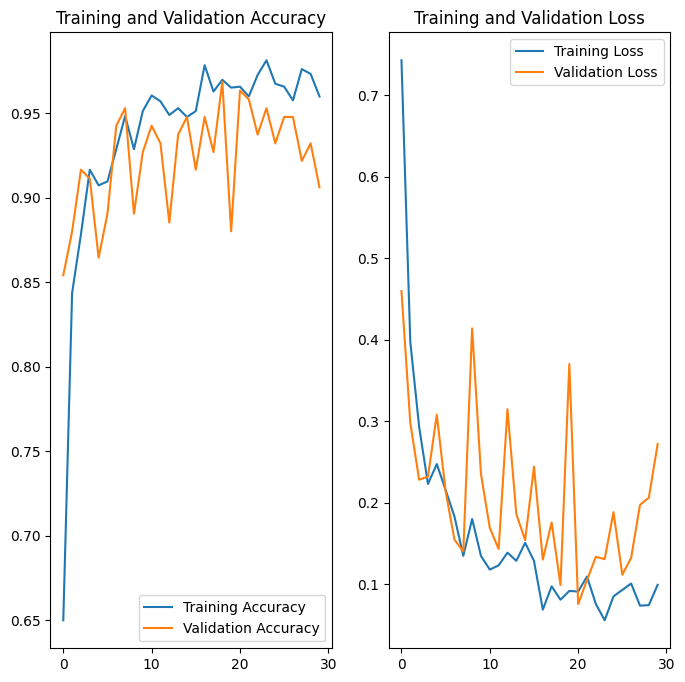

In [36]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Ít hơn 4 layer
model2 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model2.build(input_shape=batch_input_shape)

In [38]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 246016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,675 (60.14 MB)

 Trainable params: 15,764,675 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history2 = model2.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5729 - loss: 6.6495 - val_accuracy: 0.8125 - val_loss: 0.5148
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8630 - loss: 0.3516 - val_accuracy: 0.8958 - val_loss: 0.2431
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8973 - loss: 0.2496 - val_accuracy: 0.9219 - val_loss: 0.2090
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9192 - loss: 0.2286 - val_accuracy: 0.9219 - val_loss: 0.1901
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9228 - loss: 0.1983 - val_accuracy: 0.8958 - val_loss: 0.2308
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9254 - loss: 0.1875 - val_accuracy: 0.9323 - val_loss: 0.1689
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9661 - loss: 0.1153 - val_accuracy: 0.8906 - val_loss: 0.2551
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9356 - loss: 0.1644 - val_accuracy: 0.9740 - v

In [41]:
print("[INFO] Calculating model accuracy")
scores2 = model2.evaluate(test_ds)
print(f"Test Accuracy: {round(scores2[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9134 - loss: 0.2430
Test Accuracy: 90.23%


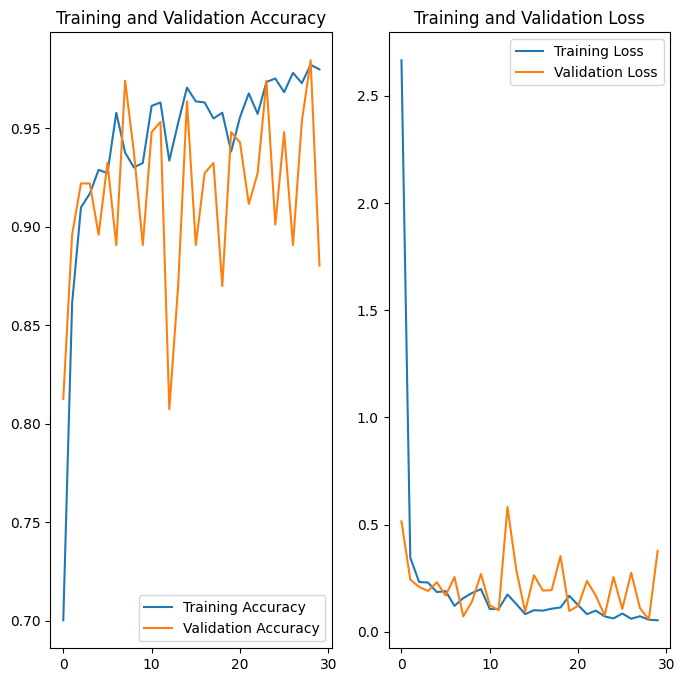

In [42]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()